uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
# from gmade import GMADE
import matplotlib.pyplot as plt
print(pyro.__version__)

pyro.set_rng_seed(0)
torch.manual_seed(0)
np.random.seed(0)

captcha_folder = 'generated_captchas'
captchaHeight = 24
captchaWidth = 60
captchaMarginX = 0
captchaMarginY = 0
batch_size = 1

char_dict = string.digits
USE_CUDA = True
MAX_N = 4 # maximum number of letters in a captcha 
MIN_N = 2 # minimum number of letters in a captcha
MIN_NOISE = 0.01 # minimum noise
MAX_NOISE = 0.99 # maximum noise
smoke_test = False
num_steps = 400 if not smoke_test else 10
TrainingSample = 5000 if not smoke_test else 100 # number of captchas generated for training 

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    
    return space + "".join(rndLetters) + space

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    return random.uniform(MIN_NOISE, MAX_NOISE)

def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        c.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        captcha_generated[len(text) - 1].append((text, image, c.noise))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[1].shape, "noise", t[2])
        if i >= 10:
            break

1.7.0
number of samples in group 0
number of samples in group 1700
text 82 captcha shape (24, 60) noise 0.9003077649970919
text 59 captcha shape (24, 60) noise 0.727964419299247
text 15 captcha shape (24, 60) noise 0.6501656276799302
text 41 captcha shape (24, 60) noise 0.7154826518984315
text 32 captcha shape (24, 60) noise 0.4724626182787427
text 14 captcha shape (24, 60) noise 0.03616390800734124
text 42 captcha shape (24, 60) noise 0.11314963153752981
text 93 captcha shape (24, 60) noise 0.9858799572401995
text 94 captcha shape (24, 60) noise 0.5099693123963349
text 87 captcha shape (24, 60) noise 0.4360361396113115
text 44 captcha shape (24, 60) noise 0.5935795083117388
number of samples in group 1653
text 048 captcha shape (24, 60) noise 0.8375334144945471
text 156 captcha shape (24, 60) noise 0.7886520360717119
text 185 captcha shape (24, 60) noise 0.64102177901862
text 899 captcha shape (24, 60) noise 0.08704548784132556
text 294 captcha shape (24, 60) noise 0.38599793670122656

text 82 noise 0.9003077649970919


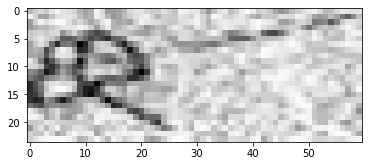

text 59 noise 0.727964419299247


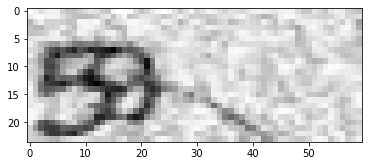

text 15 noise 0.6501656276799302


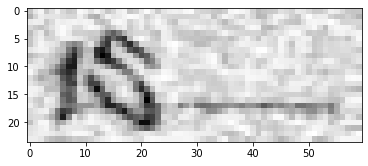

text 41 noise 0.7154826518984315


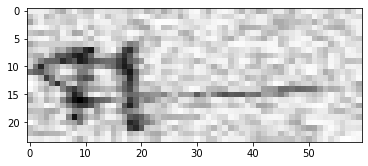

text 32 noise 0.4724626182787427


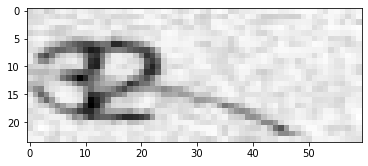

text 048 noise 0.8375334144945471


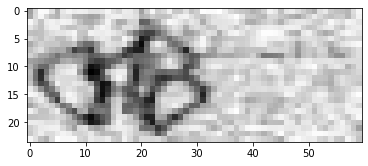

text 156 noise 0.7886520360717119


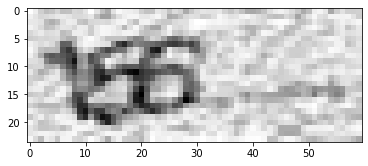

text 185 noise 0.64102177901862


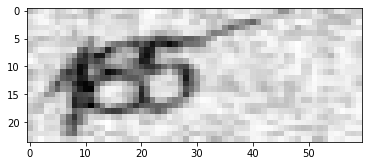

text 899 noise 0.08704548784132556


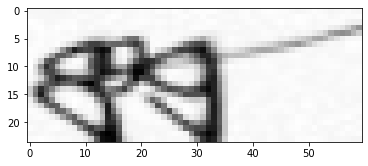

text 294 noise 0.38599793670122656


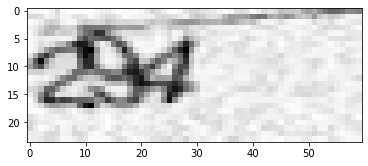

text 2129 noise 0.82354150392381


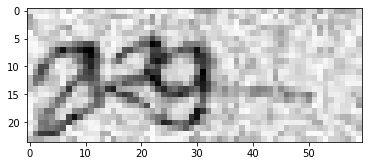

text 5422 noise 0.340207610354462


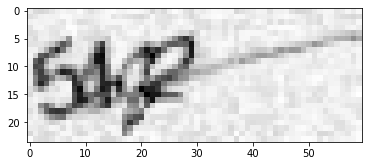

text 8961 noise 0.22890856533597448


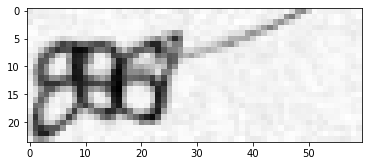

text 6024 noise 0.31343688444884715


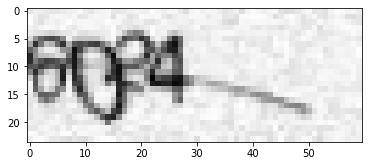

text 2181 noise 0.03507273901626142


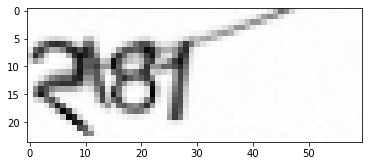

In [3]:
for lst in captcha_generated:
    for i in range(5):
        if len(lst) > 0:
            print("text", lst[i][0], "noise", lst[i][2])
            plt.imshow(255-lst[i][1], cmap="Greys")
            plt.show()
        
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# for lst in captcha_generated:
#     for i in range(5):
#         if len(lst) > 0:
#             print("text", lst[i][0], "noise", lst[i][4], "blend_alpha", lst[i][5])
#             plt.imshow(255-lst[i][1], cmap="Greys")
#             plt.show()
#             #print(255-lst[0][1])
#             plt.imshow(255-lst[i][2], cmap="Greys")
#             plt.show()
#             #print(255 - lst[0][2])
#             #plt.imshow(np.round((255-lst[0][2]) * blend_alpha + (255-lst[0][1]) * (1- blend_alpha)), cmap="Greys")
#             plt.imshow(255-lst[i][3], cmap="Greys")
#             plt.show()
#             #print(np.minimum(255, (255-lst[0][2] + 255-lst[0][1])))

In [4]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        image = self.raw_captchas[idx][1]
        noise = self.raw_captchas[idx][2]
        
        image = np.subtract(np.divide(image, 255), 0.5)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return label, image, noise

In [5]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [6]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    start = time.time()
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        img = sample_batched[1][0]
        #print("img", img.shape)
        if use_cuda:
            img = img.cuda()
        IMG = {"obs" : img.float()}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss), end="; ")
    print("Epoch takes", round(time.time()- start), "seconds")
    return loss

In [7]:
test_accuracies = []
test_char_accuracies = []
test_noise_differences = []
train_accuracies = []
train_char_accuracies = []
train_noise_differences = []

def _map_to_noise_range(input):
    noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
    input = torch.distributions.transform_to(noise_constraint)(input)
    return input


def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    global test_accuracies, test_char_accuracies, train_accuracies, train_char_accuracies, train_noise_differences, test_noise_differences
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    noise_difference = 0
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        gt_noise = t[2][0]
        img = t[1][0]

        if use_cuda:
            img = img.cuda()
        #print("test", img.shape)
        IMG = {"obs" : img.float()}
        
        posterior = csis.run(observations=IMG)
        marginal_num = pyro.infer.EmpiricalMarginal(posterior, "num_char")
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        with torch.no_grad():

            N_index = marginal_num()
            N = N_index + MIN_N
            noise = _map_to_noise_range(marginal_noise())
            sampled_chars = []
            
            # sample characters one by one
            for i in range(N):
                marginal_char = pyro.infer.EmpiricalMarginal(posterior, "char_{}".format(i))()
                if use_cuda:
                    marginal_char.cpu()
                sampled_chars.append(marginal_char)
        
        chars = ""
        for i in range(len(sampled_chars)):
            c = sampled_chars[i]
            chars +=  char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        noise_difference += abs(float(noise) - float(gt_noise))
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
 
    
    noise_difference = noise_difference / num_test_samples
    if use_train:
        train_accuracies.append(accuracy)
        train_char_accuracies.append(char_accuracy)
        train_noise_differences.append(noise_difference)
    elif n > 10:
        test_accuracies.append(accuracy)
        test_char_accuracies.append(char_accuracy)
        test_noise_differences.append(noise_difference)
    print("use_train =", use_train, "AVG Noise Difference:", noise_difference, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)

In [8]:

losses  = []
def test_cycle(use_cuda):
    
    # disable dropout
#     captchaModel.numNet.eval()
#     captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
#     captchaModel.numNet.train()
#     captchaModel.charNetSingle.train()

def optimize(start_epoch=1, use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    save_pause = 10
    print("Optimizing...")
    for t in range(start_epoch, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        losses.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
        #if (t % save_pause == 0) and (t > 0):
        #    save_and_download_checkpoints("branches-1-no-var-no-tanh_model.pt", "branches-1-no-var-no-tanh_optim.pt", "branches-1-no-var-no-tanh_param_store.pt")
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

In [9]:
# saves the model and optimizer states to disk
def save_checkpoint(currentModel, currentOptimzier, save_model, save_opt, save_param_store):
    print("saving model to %s..." % save_model)
    torch.save(currentModel.state_dict(), save_model)
    print("saving optimizer states to %s..." % save_opt)
    currentOptimzier.save(save_opt)
    print("saving pyro pram store states to %s..." % save_param_store)
    pyro.get_param_store().save(save_param_store)
    print("done saving checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint(myModel, myOptimzer, load_model, load_opt, load_param_store):
    pyro.clear_param_store()
    print("loading model from %s..." % load_model)
    myModel.load_state_dict(torch.load(load_model))
    print("loading optimizer states from %s..." % load_opt)
    myOptimzer.load(load_opt)
    print("loading pyro pram store states from %s..." % load_param_store)
    pyro.get_param_store().load(load_param_store)
    print("done loading states.")
    pyro.module("guide", myModel, update_module_params=True)

def save_and_download_checkpoints(save_model, save_opt, save_param_store):
    save_checkpoint(captchaModel, optimiser, save_model, save_opt, save_param_store)
def save_metric_to_disk(file_path):
    import json
    save_dict = {
        "test_accuracies" : test_accuracies,
        "test_char_accuracies" : test_char_accuracies,
        "test_noise_differences" : test_noise_differences,
        "train_accuracies"  : train_accuracies,
        "train_char_accuracies"  : train_char_accuracies,
        "train_noise_differences" : train_noise_differences,
    }
    print(save_dict)
    with open(file_path, 'w') as fout:
        json.dump(save_dict, fout)

In [10]:
import guide_lstm_v2 as guide
import model

In [11]:
class ObsEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, img):
        #print(img.shape)
        img = img.unsqueeze(0).unsqueeze(0).float()

        img = self.pool(F.relu(self.conv1(img)))
        #print(img.shape)
        img = self.pool(F.relu(self.conv2(img)))
        #print(img.shape)

        img = self.pool(F.relu(self.conv3(img)))
        #print(img.shape)
        
        return img
obs_embedding = ObsEmbedding().cuda()

In [12]:
def wrapped_guide(observations):
    pyro.module("obs_embedding", obs_embedding)
    emb_obs = obs_embedding(observations['obs'])
    return guide.model({'obs':emb_obs})
    

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n0 = count_parameters(obs_embedding)
n1 = count_parameters(guide.lstm_wrap)
n2 = count_parameters(guide._nn_model_char_char_i)
n3 = count_parameters(guide._nn_model_noise)
n4 = count_parameters(guide._nn_model_num_char)
print(n0, n1, n2, n3, n4, "total:", n0+n1+n2+n3+n4)

222080 3924302 2098842 739330 740355 total: 7724909


In [14]:
optimiser = pyro.optim.Adam({'lr': 2e-4})
csis = pyro.infer.CSIS(model.model, wrapped_guide, optimiser, num_inference_samples=1)

optimize(1, USE_CUDA)
# test_cycle(USE_CUDA)
save_metric_to_disk("captcha_guide3.json")


Optimizing...


C:\Users\frank\anaconda3\envs\pyro-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\captcha\guide_lstm_v2.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  num_char = P.sample('num_char', PD.Categorical(TN.LogSoftmax()(T.reshape(
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\captcha\guide_lstm_v2.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  char_i = P.sample(f'char_{i}', PD.Categorical(TN.LogSoftmax()(T.resh

loss at epoch 1 is 5.733519389983103; Epoch takes 1918 seconds
loss at epoch 2 is 2.3473522114647674; Epoch takes 2076 seconds
loss at epoch 3 is 0.912100494089866; Epoch takes 2079 seconds
loss at epoch 4 is 0.1525196786331407; Epoch takes 2071 seconds
loss at epoch 5 is -0.19644984787813582; Epoch takes 2068 seconds
use_train = True AVG Noise Difference: 0.042472742533361384 Total correct: 2735 accuracy:2735/5000= 0.547 char_accuracy:11991/14947= 0.8022345621194888
use_train = False AVG Noise Difference: 0.04243516541211442 Total correct: 533 accuracy:533/1000= 0.533 char_accuracy:2370/2991= 0.7923771313941825
N_predicted: 4 | Actual N: 3 | Predicted Noise: 0.168 | Actual Noise: 0.02 | Predicted Text: 0110 | Actual Text: 010 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.257 | Actual Noise: 0.173 | Predicted Text: 913 | Actual Text: 933 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.143 | Actual Noise: 0.091 | Predicted Text: 41 | Actual Text: 41 | Cor

loss at epoch 21 is -1.105854207497842; Epoch takes 1775 seconds
loss at epoch 22 is -1.0940468085964004; Epoch takes 1774 seconds
loss at epoch 23 is -1.111778250723424; Epoch takes 1775 seconds
loss at epoch 24 is -1.1223559219151924; Epoch takes 1814 seconds
loss at epoch 25 is -1.1323801676172869; Epoch takes 1918 seconds
use_train = True AVG Noise Difference: 0.038591836907792026 Total correct: 3970 accuracy:3970/5000= 0.794 char_accuracy:13726/14947= 0.9183113668294641
use_train = False AVG Noise Difference: 0.03809888148816363 Total correct: 792 accuracy:792/1000= 0.792 char_accuracy:2741/2982= 0.9191817572099262
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.48 | Actual Noise: 0.477 | Predicted Text: 32 | Actual Text: 32 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.187 | Actual Noise: 0.035 | Predicted Text: 374 | Actual Text: 374 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.233 | Actual Noise: 0.203 | Predicted Text: 5399 | Actual Text: 5

loss at epoch 41 is -1.2545740026290662; Epoch takes 1813 seconds
loss at epoch 42 is -1.2663263361434276; Epoch takes 1780 seconds
loss at epoch 43 is -1.2606637718476785; Epoch takes 1772 seconds
loss at epoch 44 is -1.2831387375221275; Epoch takes 1778 seconds
loss at epoch 45 is -1.2843914418244182; Epoch takes 1782 seconds
use_train = True AVG Noise Difference: 0.03922051425700111 Total correct: 4040 accuracy:4040/5000= 0.808 char_accuracy:13863/14947= 0.9274770857028166
use_train = False AVG Noise Difference: 0.04048822669845784 Total correct: 805 accuracy:805/1000= 0.805 char_accuracy:2742/2958= 0.9269776876267748
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.707 | Actual Noise: 0.716 | Predicted Text: 281 | Actual Text: 281 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.453 | Actual Noise: 0.458 | Predicted Text: 8228 | Actual Text: 8228 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.913 | Actual Noise: 0.937 | Predicted Text: 88 | Actual Tex

loss at epoch 61 is -1.3451959357602026; Epoch takes 1917 seconds
loss at epoch 62 is -1.349020828241203; Epoch takes 1884 seconds
loss at epoch 63 is -1.35513851164739; Epoch takes 1798 seconds
loss at epoch 64 is -1.3545334217965226; Epoch takes 1789 seconds
loss at epoch 65 is -1.3631343621476804; Epoch takes 1792 seconds
use_train = True AVG Noise Difference: 0.030777982903224796 Total correct: 4142 accuracy:4142/5000= 0.8284 char_accuracy:13997/14947= 0.93644209540376
use_train = False AVG Noise Difference: 0.03170314270494551 Total correct: 831 accuracy:831/1000= 0.831 char_accuracy:2878/3064= 0.9392950391644909
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.747 | Actual Noise: 0.738 | Predicted Text: 9585 | Actual Text: 9885 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.559 | Actual Noise: 0.541 | Predicted Text: 1198 | Actual Text: 1198 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.759 | Actual Noise: 0.795 | Predicted Text: 3500 | Actual Te

loss at epoch 81 is -1.4104685603786187; Epoch takes 1834 seconds
loss at epoch 82 is -1.3968709125940284; Epoch takes 1812 seconds
loss at epoch 83 is -1.4088344848719132; Epoch takes 1805 seconds
loss at epoch 84 is -1.40982450316816; Epoch takes 1794 seconds
loss at epoch 85 is -1.4026578464168387; Epoch takes 1821 seconds
use_train = True AVG Noise Difference: 0.032907045056365804 Total correct: 4181 accuracy:4181/5000= 0.8362 char_accuracy:14055/14947= 0.9403224727370041
use_train = False AVG Noise Difference: 0.033199426924019164 Total correct: 840 accuracy:840/1000= 0.84 char_accuracy:2819/3001= 0.939353548817061
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.243 | Actual Noise: 0.183 | Predicted Text: 80 | Actual Text: 80 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.207 | Actual Noise: 0.188 | Predicted Text: 9085 | Actual Text: 9085 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.512 | Actual Noise: 0.494 | Predicted Text: 22 | Actual Text: 

loss at epoch 101 is -1.4385270239952446; Epoch takes 1785 seconds
loss at epoch 102 is -1.4410013674703162; Epoch takes 1786 seconds
loss at epoch 103 is -1.4437788073050746; Epoch takes 1784 seconds
loss at epoch 104 is -1.4385861166996656; Epoch takes 1789 seconds
loss at epoch 105 is -1.4371693515328459; Epoch takes 1789 seconds
use_train = True AVG Noise Difference: 0.030233902913953697 Total correct: 4228 accuracy:4228/5000= 0.8456 char_accuracy:14073/14947= 0.9415267277714592
use_train = False AVG Noise Difference: 0.03033729174266626 Total correct: 830 accuracy:830/1000= 0.83 char_accuracy:2842/3028= 0.9385733157199472
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.894 | Actual Noise: 0.887 | Predicted Text: 26 | Actual Text: 26 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.159 | Actual Noise: 0.134 | Predicted Text: 744 | Actual Text: 744 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.718 | Actual Noise: 0.699 | Predicted Text: 7645 | Actual

loss at epoch 121 is -1.468451980726888; Epoch takes 1805 seconds
loss at epoch 122 is -1.4629952736603062; Epoch takes 1813 seconds
loss at epoch 123 is -1.4619941279276503; Epoch takes 1816 seconds
loss at epoch 124 is -1.4655875643038274; Epoch takes 1789 seconds
loss at epoch 125 is -1.465028256850495; Epoch takes 1787 seconds
use_train = True AVG Noise Difference: 0.025365560786943145 Total correct: 4300 accuracy:4300/5000= 0.86 char_accuracy:14174/14947= 0.9482839365759015
use_train = False AVG Noise Difference: 0.02676571668674738 Total correct: 862 accuracy:862/1000= 0.862 char_accuracy:2823/2982= 0.9466800804828974
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.618 | Actual Noise: 0.647 | Predicted Text: 625 | Actual Text: 625 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.172 | Actual Noise: 0.142 | Predicted Text: 6745 | Actual Text: 6745 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.4 | Actual Noise: 0.383 | Predicted Text: 24 | Actual Te

loss at epoch 141 is -1.4833075369158562; Epoch takes 1790 seconds
loss at epoch 142 is -1.4728619263988998; Epoch takes 1792 seconds
loss at epoch 143 is -1.4872424753895228; Epoch takes 1786 seconds
loss at epoch 144 is -1.4986266268862682; Epoch takes 1788 seconds
loss at epoch 145 is -1.483958834441982; Epoch takes 1783 seconds
use_train = True AVG Noise Difference: 0.031216659540983027 Total correct: 4279 accuracy:4279/5000= 0.8558 char_accuracy:14143/14947= 0.94620994179434
use_train = False AVG Noise Difference: 0.03211172508802009 Total correct: 859 accuracy:859/1000= 0.859 char_accuracy:2827/2988= 0.9461178045515395
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.424 | Actual Noise: 0.427 | Predicted Text: 266 | Actual Text: 266 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.61 | Actual Noise: 0.591 | Predicted Text: 34 | Actual Text: 34 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.5 | Actual Noise: 0.502 | Predicted Text: 1338 | Actual Text

loss at epoch 161 is -1.5035049848864803; Epoch takes 1824 seconds
loss at epoch 162 is -1.4982788342796487; Epoch takes 1842 seconds
loss at epoch 163 is -1.5056500359372336; Epoch takes 1861 seconds
loss at epoch 164 is -1.5097667552246938; Epoch takes 1843 seconds
loss at epoch 165 is -1.5090170494621153; Epoch takes 1787 seconds
use_train = True AVG Noise Difference: 0.02659248174627078 Total correct: 4281 accuracy:4281/5000= 0.8562 char_accuracy:14146/14947= 0.9464106509667491
use_train = False AVG Noise Difference: 0.026260362490300674 Total correct: 866 accuracy:866/1000= 0.866 char_accuracy:2845/2999= 0.94864954984995
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.207 | Actual Noise: 0.198 | Predicted Text: 03 | Actual Text: 03 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.49 | Actual Noise: 0.478 | Predicted Text: 3372 | Actual Text: 3372 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.163 | Actual Noise: 0.175 | Predicted Text: 01 | Actual T

loss at epoch 181 is -1.501060500362125; Epoch takes 1789 seconds
loss at epoch 182 is -1.5127633208579327; Epoch takes 1788 seconds
loss at epoch 183 is -1.5184904047995453; Epoch takes 1789 seconds
loss at epoch 184 is -1.5263046799241347; Epoch takes 1787 seconds
loss at epoch 185 is -1.5159513962829858; Epoch takes 1785 seconds
use_train = True AVG Noise Difference: 0.027938721859363223 Total correct: 4336 accuracy:4336/5000= 0.8672 char_accuracy:14203/14947= 0.9502241252425235
use_train = False AVG Noise Difference: 0.02783710412773572 Total correct: 851 accuracy:851/1000= 0.851 char_accuracy:2835/2997= 0.9459459459459459
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.607 | Actual Noise: 0.618 | Predicted Text: 21 | Actual Text: 27 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.205 | Actual Noise: 0.152 | Predicted Text: 463 | Actual Text: 465 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.356 | Actual Noise: 0.337 | Predicted Text: 66 | Actual T

KeyboardInterrupt: 

# 